# Exercise 2 - Camden broadband

(Credit to James Cheshire (UCL) for the data and the outline of the challenge)

## Part 1: make a choropleth map of median internet speeds in 2017 in Camden.

The files "resources/bband_camden.csv" and "resources/bband_camden.shp" should contain the same information (check!), but the .shp contains polygons that can be drawn with the *geopandas* package.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

Lets have a first look at the bband_camden csv file:

In [2]:
df_csv = pd.read_csv("resources/bband_camden.csv")
df_csv.head()

,OA11CD,Median16,Mean16,Min16,Max16,Median17,Mean17,Min17,Max17,LSOA11CD
0,E00004527,18.784615,27.400000,5.592308,92.338462,19.620000,32.833333,7.986667,102.220000,E01000918
1,E00004525,24.220000,33.200000,13.133333,83.860000,25.072727,36.690909,11.300000,103.709091,E01000918
2,E00004522,23.172727,29.890909,8.259091,83.390909,25.223810,34.119048,10.123810,100.542857,E01000919
3,E00004287,37.550000,49.350000,14.900000,150.500000,54.500000,58.020000,17.800000,180.000000,E01000875
4,E00004206,34.925000,51.225000,15.850000,138.000000,49.950000,62.625000,11.600000,175.000000,E01000858


In [3]:
df_csv.shape

(749, 10)

So there are 749 rows, and columns showing min, max, mean, median broadband speeds (presumably download speed in Mbit/s) for 2016 and 2017.  

There are also columns for "OA" (Output Area) and "LSOA" (Lower Layer Super Output Area).  These are nationwide naming schemes for geographic areas. OAs are the smallest areas, containing clusters of adjacent postcodes. An LSOA is a group of OAs, containing between 1000 and 1500 people.

How many OAs and LSOAs do we have?

In [4]:
print("Numbers of OA, LSOA: {} {}".format(len(df_csv["OA11CD"].unique()),len(df_csv["LSOA11CD"].unique())))

Numbers of OA, LSOA: 749 133


So we have one OA per row of the data frame, and on average about 6 OAs per LSOA.

Now lets read in the shape file, and check it is consistent with the csv:

In [5]:
df_shp = gpd.read_file("resources/bband_camden.shp")
df_shp.columns

Index(['OA11CD', 'Median16', 'Mean16', 'Min16', 'Max16', 'Median17', 'Mean17',
       'Min17', 'Max17', 'LSOA11CD', 'geometry'],
      dtype='object')

In [6]:
for col in list(df_csv.columns):
    print(col, df_csv[col].equals(df_shp[col]))
    

OA11CD True
Median16 False
Mean16 False
Min16 False
Max16 False
Median17 False
Mean17 False
Min17 False
Max17 False
LSOA11CD True


That's weird!  The OA11CD and LSOA11CD columns are identical, but all the other ones (containing numerical data) don't match...   Could it be that the types are different?

In [7]:
print("{} \n \n {}".format(df_csv.dtypes, df_shp.dtypes))

OA11CD       object
Median16    float64
Mean16      float64
Min16       float64
Max16       float64
Median17    float64
Mean17      float64
Min17       float64
Max17       float64
LSOA11CD     object
dtype: object 
 
 OA11CD      object
Median16    object
Mean16      object
Min16       object
Max16       object
Median17    object
Mean17      object
Min17       object
Max17       object
LSOA11CD    object
geometry    object
dtype: object


So, annoyingly, although *pd.read_csv* convert the numerical columns into float64, *gpd.read_file* left them as strings!   

Never mind, lets convert them into numbers then compare again:

In [8]:
for col in list(df_shp.columns):
    if col.startswith("M"):
        df_shp[col] = pd.to_numeric(df_shp[col])

In [10]:
for col in list(df_csv.columns):
    print(col, df_csv[col].equals(df_shp[col]))

OA11CD True
Median16 True
Mean16 True
Min16 True
Max16 True
Median17 True
Mean17 True
Min17 True
Max17 True
LSOA11CD True


Great!

So now, we can just use the shape file.   

Plotting all the OAs on a map gives us an opportunity to check for missing records - any OAs that don't have a row in the dataframe would show up as a gap in the map.

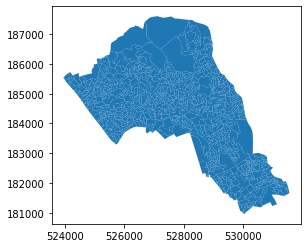

In [11]:
df_shp.geometry.plot()


OK, so there don't seem to be any missing records.   How about missing values?

In [12]:
for col in list(df_shp.columns):
    print(col, df_shp[col].count())

OA11CD 749
Median16 743
Mean16 744
Min16 745
Max16 745
Median17 745
Mean17 745
Min17 745
Max17 745
LSOA11CD 749
geometry 749


In [13]:
df_missing = df_shp[df_shp.isnull().any(axis=1)]
df_missing

,OA11CD,Median16,Mean16,Min16,Max16,Median17,Mean17,Min17,Max17,LSOA11CD,geometry
379,E00004359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E01000885,"POLYGON ((525860.5330000001 185918.412, 525897..."
388,E00004506,NaN,38.166667,3.666667,166.666667,40.000,48.600,3.933333,200.0,E01000908,"POLYGON ((528908.643 186523.415, 528908.542999..."
423,E00004684,NaN,NaN,7.050000,200.000000,15.950,42.100,4.200000,150.0,E01000949,"POLYGON ((528949.129 182882.478, 528985.745 18..."
486,E00004692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E01000944,"POLYGON ((528853.388 182768.051, 528853.809 18..."
548,E00004549,18.3,38.750000,4.575000,175.000000,NaN,NaN,NaN,NaN,E01000917,"POLYGON ((531196.101 181933.69, 531196.4129999..."
654,E00004226,NaN,NaN,NaN,NaN,63.125,71.875,8.925000,175.0,E01000857,"POLYGON ((527626.654 184095.506, 527628.738999..."
688,E00174676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E01000852,"POLYGON ((530033.523 182271.791, 530010.199 18..."


So it looks like the missing values are typically all the measurements for a given OA for 2016 and/or 2017.
Since we only care about 2017 for this analysis, let's just exclude those rows:

In [14]:
df_shp = df_shp[df_shp["Median17"].notnull()]
df_shp.shape

(745, 11)

Let's make plots of min, max, median, mean to sanity-check values:

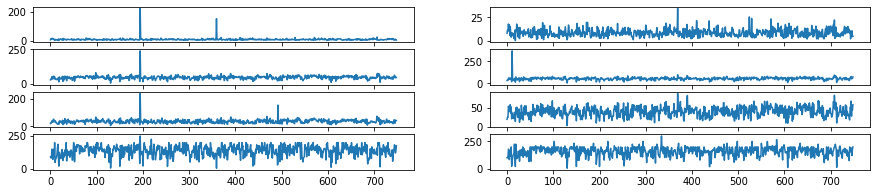

In [15]:
fig, axes = plt.subplots(4,2, figsize=(15,3))
for i, var in enumerate(["Min","Mean","Median","Max"]):
    for j, year in enumerate(["16","17"]): 
        axes[i][j].plot(df_shp[var+year])

Some suspicious things there.... the spikes in the 2016 min, median, mean and the 2017 mean must be wrong...  Let's write a simple function to check that min < (mean|median)< max

In [16]:
def check_row(i,row):
    
    for year in ["16","17"]:
        if row["Min"+year] > row["Mean"+year] or\
        row["Min"+year] > row["Median"+year] or\
        row["Min"+year] > row["Max"+year] or\
        row["Median"+year] > row["Max"+year] or\
        row["Mean"+year] > row["Max"+year]: 
            print("{} {}: {}: {} {} {} {}".format(
                i,
                row["OA11CD"],
                year,
                row["Min"+year],
                row["Mean"+year],
                row["Median"+year],
                row["Max"+year],
            ))
 
for i, row in df_shp.iterrows():
    check_row(i,row)


11 E00174657: 17: 8.5 367.0 36.58 73.8
359 E00004442: 16: 151.66666669999998 41.6 30.13333333 6.1666
492 E00004699: 16: 6.1769230770000005 20.31538462 152.23076919999997 49.36153846


So for OA E00174657 it looks like there is a decimal point missing - the mean should be 36.7 not 367.

For OA E00004442 it looks like min and max could be swapped.

For OA E00004699 perhaps median and max are swapped.

We can make the changes to fix these, but it is very important that we *make a note of what we're doing!*.

In [17]:
df_shp.at[11,"Mean17"] = 36.7 
df_shp.at[359,"Min16"] = 6.166
df_shp.at[359,"Max16"] = 151.67
df_shp.at[492,"Median16"] = 49.36
df_shp.at[492,"Max16"] = 152.23

Let's check that worked:

In [18]:
df_shp.loc[11]

OA11CD                                              E00174657
Median16                                                35.14
Mean16                                                  33.52
Min16                                                    8.28
Max16                                                   72.86
Median17                                                36.58
Mean17                                                   36.7
Min17                                                     8.5
Max17                                                    73.8
LSOA11CD                                            E01000869
geometry    POLYGON ((529685.791 184824.648, 529665.186 18...
Name: 11, dtype: object

OK, let's go ahead and make the choropleth map.

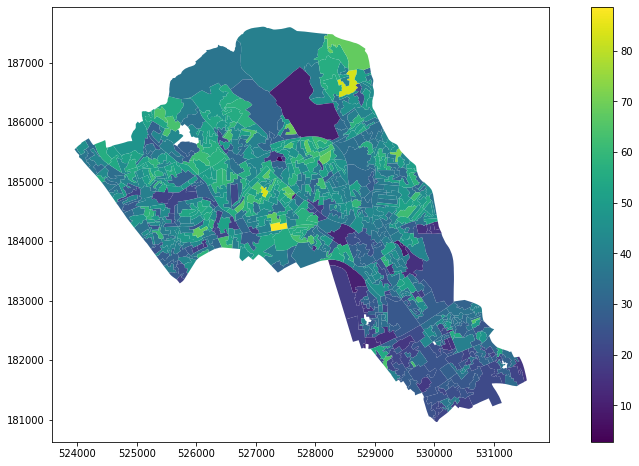

In [19]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
df_shp.plot(column="Median17",ax=ax, legend=True)

## Part 2 - combine with internet user classification data

The file "resources/iuc2018.csv" contains a label per LSOA of typical internet users within that region.

### Challenge: make a plot of minimum broadband speed per LSOA per category of internet user.

In [21]:
df_iuc = pd.read_csv("resources/iuc2018.csv")
df_iuc.head()

,SHP_ID,LSOA11_CD,LSOA11_NM,GRP_CD,GRP_LABEL
0,36735,S01009308,Abbey Parks North,4,Youthful Urban Fringe
1,36736,S01009309,Abbey Parks South and Brucefield North West,3,e-Veterans
2,36321,S01008686,Abbeyhill - 01,7,Passive and Uncommitted Users
3,6994,S01008687,Abbeyhill - 02,2,e-Professionals
4,36322,S01008688,Abbeyhill - 03,2,e-Professionals


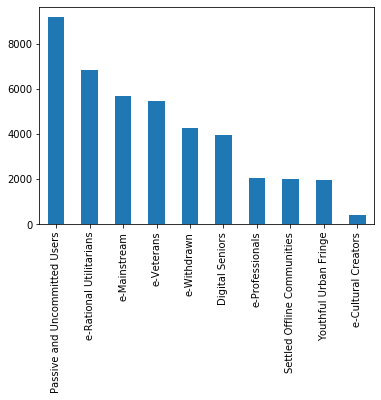

In [22]:
df_iuc["GRP_LABEL"].value_counts().plot(kind="bar")

We're going to want to join the two dataframes, using the LSOA.  Let's first rename the column in the new dataframe so it matches:

In [23]:
df_iuc = df_iuc.rename(columns={"LSOA11_CD": "LSOA11CD"})
df_iuc.columns

Index(['SHP_ID', 'LSOA11CD', 'LSOA11_NM', 'GRP_CD', 'GRP_LABEL'], dtype='object')

In [24]:
df_new = df_shp.merge(df_iuc)
df_new.head()

,OA11CD,Median16,Mean16,Min16,Max16,Median17,Mean17,Min17,Max17,LSOA11CD,geometry,SHP_ID,LSOA11_NM,GRP_CD,GRP_LABEL
0,E00004527,18.784615,27.400000,5.592308,92.338462,19.620000,32.833333,7.986667,102.220000,E01000918,"POLYGON ((530648.449 181230.247, 530648.042 18...",21257,Camden 028C,4,Youthful Urban Fringe
1,E00004525,24.220000,33.200000,13.133333,83.860000,25.072727,36.690909,11.300000,103.709091,E01000918,"POLYGON ((530511.3149999999 181531.164, 530511...",21257,Camden 028C,4,Youthful Urban Fringe
2,E00004560,21.954545,35.572727,9.872727,126.772727,23.418182,38.500000,10.054545,140.400000,E01000918,"POLYGON ((530421.01 181558.385, 530420.653 181...",21257,Camden 028C,4,Youthful Urban Fringe
3,E00004561,21.590909,39.018182,8.390909,123.045454,20.611111,39.544444,7.400000,128.377778,E01000918,"POLYGON ((530190 181481.999, 530187 181480, 53...",21257,Camden 028C,4,Youthful Urban Fringe
4,E00004558,25.333333,35.058333,10.125000,98.108333,26.850000,37.591667,12.441667,97.200000,E01000918,"POLYGON ((530406 181578, 530388 181565, 530386...",21257,Camden 028C,4,Youthful Urban Fringe


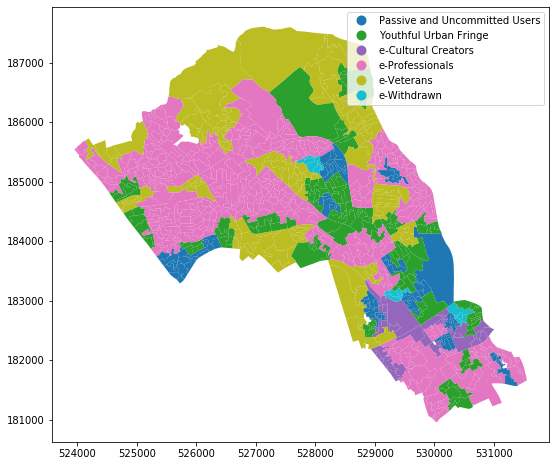

In [25]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
df_new.plot(column="GRP_LABEL",ax=ax, legend=True)

OK, so, suppose we want to look at internet speeds per group.  

We don't have the populations of each OA within an LSOA, so we can't accurately calculate medians or means for the whole LSOA, but we can look at min or max speeds per LSOA.

In [26]:
df_new["Min17_LSOA"] = df_new.groupby("LSOA11CD")["Min17"].transform("min")
df_new["Max17_LSOA"] = df_new.groupby("LSOA11CD")["Max17"].transform("max")

In [27]:
df_new.head(10)

,OA11CD,Median16,Mean16,Min16,Max16,Median17,Mean17,Min17,Max17,LSOA11CD,geometry,SHP_ID,LSOA11_NM,GRP_CD,GRP_LABEL,Min17_LSOA,Max17_LSOA
0,E00004527,18.784615,27.400000,5.592308,92.338462,19.620000,32.833333,7.986667,102.220000,E01000918,"POLYGON ((530648.449 181230.247, 530648.042 18...",21257,Camden 028C,4,Youthful Urban Fringe,7.40,160.806667
1,E00004525,24.220000,33.200000,13.133333,83.860000,25.072727,36.690909,11.300000,103.709091,E01000918,"POLYGON ((530511.3149999999 181531.164, 530511...",21257,Camden 028C,4,Youthful Urban Fringe,7.40,160.806667
2,E00004560,21.954545,35.572727,9.872727,126.772727,23.418182,38.500000,10.054545,140.400000,E01000918,"POLYGON ((530421.01 181558.385, 530420.653 181...",21257,Camden 028C,4,Youthful Urban Fringe,7.40,160.806667
3,E00004561,21.590909,39.018182,8.390909,123.045454,20.611111,39.544444,7.400000,128.377778,E01000918,"POLYGON ((530190 181481.999, 530187 181480, 53...",21257,Camden 028C,4,Youthful Urban Fringe,7.40,160.806667
4,E00004558,25.333333,35.058333,10.125000,98.108333,26.850000,37.591667,12.441667,97.200000,E01000918,"POLYGON ((530406 181578, 530388 181565, 530386...",21257,Camden 028C,4,Youthful Urban Fringe,7.40,160.806667
5,E00004559,21.825000,36.081250,9.362500,119.112500,28.266667,47.493333,9.673333,160.480000,E01000918,"POLYGON ((530287.153 181673.623, 530276.684 18...",21257,Camden 028C,4,Youthful Urban Fringe,7.40,160.806667
6,E00004528,29.992857,42.821429,10.650000,136.342857,38.100000,53.146667,10.680000,160.806667,E01000918,"POLYGON ((530412.508 181374.236, 530411.676 18...",21257,Camden 028C,4,Youthful Urban Fringe,7.40,160.806667
7,E00004522,23.172727,29.890909,8.259091,83.390909,25.223810,34.119048,10.123810,100.542857,E01000919,"POLYGON ((530207 181434, 530209.5600000001 181...",17562,Camden 028D,2,e-Professionals,7.86,140.958333
8,E00004529,19.057143,27.467857,8.500000,91.310714,20.688000,34.132000,7.860000,119.984000,E01000919,"POLYGON ((530202.096 181211.041, 530201 181210...",17562,Camden 028D,2,e-Professionals,7.86,140.958333
9,E00004526,26.866667,38.833333,10.725000,101.441667,36.683333,47.516667,15.191667,120.433333,E01000919,"POLYGON ((530262.368 181340.822, 530258.143 18...",17562,Camden 028D,2,e-Professionals,7.86,140.958333


Now lets plot this on a map:

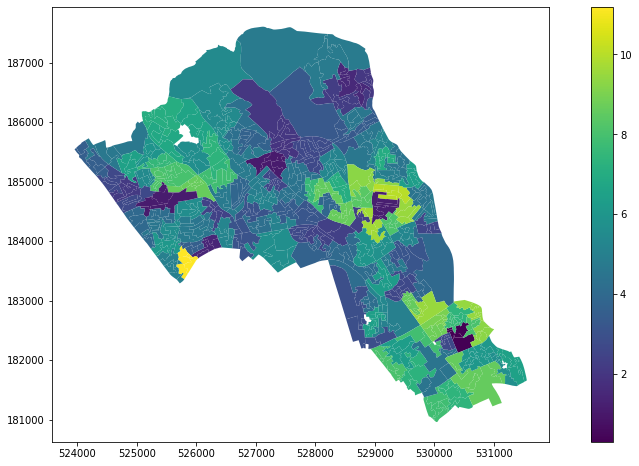

In [28]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
df_new.plot(column="Min17_LSOA",ax=ax, legend=True)

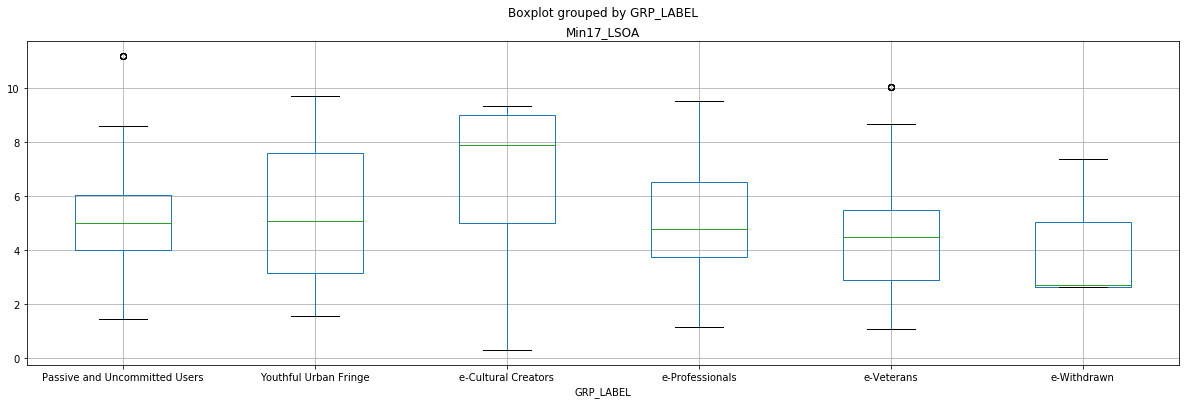

In [29]:
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_new.boxplot(column="Min17_LSOA",by="GRP_LABEL",ax=ax)

So, on average, it looks like Camden's "***e-Cultural Creators***" have the highest minimum broadband speed.